# Text2Cypher Workflow Demo Notebook

This notebooks demonstrates a text2cypher workflow with visualization capabilities.

## Imports

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [1]:
import asyncio
from IPython.display import Image, display

from langchain_neo4j import Neo4jGraph
from langchain_openai import ChatOpenAI

from ps_genai_agents.workflows.multi_agent import create_text2cypher_with_visualization_workflow
from ps_genai_agents.components.state import OutputState
from ps_genai_agents.retrievers.cypher_examples import YAMLCypherExampleRetriever

## Neo4j Graph

This class handles interaction with our Neo4j database. We use `enhanced_schema` to gain more detail about the graph contents.

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
graph = Neo4jGraph(enhanced_schema=True)

In [4]:
print(graph.schema)

Node properties:
- **Customer**
  - `id`: STRING Example: "9A79438B"
  - `ageBucket`: STRING Example: ">=70"
  - `gender`: STRING Available options: ['Male', 'Female', '']
- **Category**
  - `id`: STRING Available options: ['Exterior', 'Driving Experience', 'Features/Controls/Displays (FCD)', 'Driving Assistance', 'Infotainment', 'Seats', 'Climate', 'Interior', 'Powertrain']
- **Problem**
  - `id`: STRING Example: "EXT01"
  - `problem`: STRING Example: "EXT01: Doors - Hard to open/close"
- **Question**
  - `id`: INTEGER Min: 1, Max: 223
  - `question`: STRING Example: "#001 Doors Hard to Open/Close"
- **Vehicle**
  - `id`: STRING Example: "Acura Integra"
  - `totalProblems`: INTEGER Min: 2, Max: 10
- **Verbatim**
  - `id`: STRING Example: "9323AB5C"
  - `verbatim`: STRING Example: "It doesn't work if I have my phone in the car.  Th"
  - `verbatimText`: STRING Example: "acura rdx infotainment info13: built-in navigation"
  - `severity`: FLOAT Example: "3.0"
  - `gender`: STRING Example:

## LLM

We will be using an OpenAI LLM for this demo.

In [5]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

## Cypher Example Retriever

This class is responsible for collecting and formatting Cypher examples for few shot prompting.

In [6]:
cypher_query_yaml_file_path = "./data/iqs/queries/queries.yml"
cypher_example_retriever = YAMLCypherExampleRetriever(cypher_query_yaml_file_path=cypher_query_yaml_file_path)

## Agent

In [7]:
scope_description = "This application may answer questions related to customer feedback on Honda vehicles."

In [8]:
agent = create_text2cypher_with_visualization_workflow(llm=llm, 
                                                       graph=graph, 
                                                       scope_description=scope_description, 
                                                       cypher_example_retriever=cypher_example_retriever, 
                                                       llm_cypher_validation=False, 
                                                       attempt_cypher_execution_on_final_attempt=True)

Here we can see the agent workflow. 
* The workflow always starts at `guardrails` where the input question is determined to be in scope or not.
* The workflow always ends at `final_answer` where the generated contents are formatted to be returned to the user.
* Dotted lines indicate conditional paths.

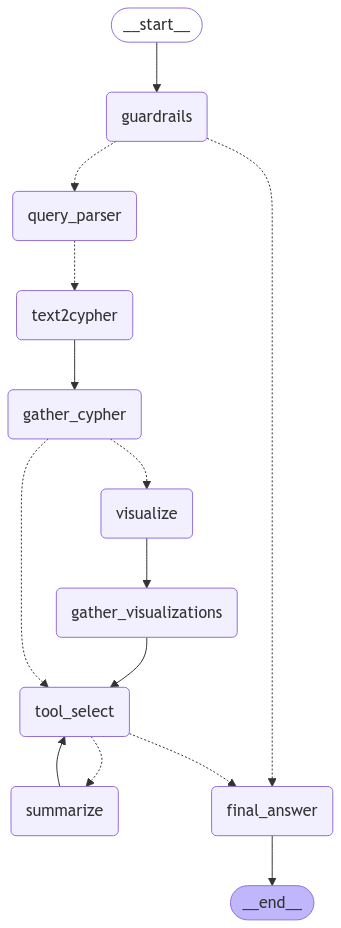

In [9]:
display(Image(agent.get_graph().draw_mermaid_png()))

## Questions

### Helper Functions

In [10]:
async def ask_question(question: str, debug: bool = False) -> OutputState:
    """wrapper to simplify asking questions in the notebook."""

    async def ask():
        response = await agent.ainvoke({"question": question}, debug=debug)
        return response

    return asyncio.run(ask())

def print_answer(response: OutputState) -> None:
    print(response.get("question"))
    print(response.get("answer"))

def print_cypher_queries(response: OutputState) -> None:

   [print(c.get("subquestion") + "\n\n" + c.get("statement")+"\n\n") for c in response.get("cyphers")]

def print_cypher_results(response: OutputState) -> None:

    [(print(c.get("subquestion") + "\n\n"), [print(r) for r in c.get("records")], print("\n\n")) for c in response.get("cyphers")]

def print_viz_results(response: OutputState) -> None:
    [
        (print(v.get("subquestion") + "\n\n" + v.get("chart_description") + "\n\n"), display(v.get("chart"))) for v in response.get("visualizations")
    ]

The agent response is a Python dictionary with the following format:
```python
{
    answer: str,
    question: str,
    steps: List[str],
    cyphers: List[
        subquestion: str,
        statement: str,
        errors: List[str],
        records: List[Dict[str, Any]],
        next_action: str,
        steps: List[str],
    ],
    visualizations: List[
        subquestion: str
        chart: Any
        chart_description: str
        steps: List[str]
    ]
}
```

### 1. Out of Scope

The agent can detect whether a question is in scope and avoid further processing.

In [13]:
q1 = await ask_question("What are the most common apple types?")

In [14]:
print_answer(q1)

What are the most common apple types?
This question is out of scope. Therefore I cannot answer this question.


We can see the agent only performs 2 steps - only `guardrails` requires an LLM call.

In [15]:
q1.get("steps")

['guardrails', 'final_answer']

### 2. Cypher Question without Visualization

The agent is capable of creating Cypher queries to answer questions within the scope of the data.

In [11]:
q2 = await ask_question("How many vehicles are there?")

In [12]:
print_answer(q2)

How many vehicles are there?
There are 12 vehicles.


All Cypher queries are saved for evaluation.

In [13]:
print_cypher_queries(q2)

What is the total number of vehicles?

MATCH (v:Vehicle)
RETURN COUNT(v) AS totalVehicles




Results are saved as well for evaluation or futher processing.

In [14]:
print_cypher_results(q2)

What is the total number of vehicles?


{'totalVehicles': 12}





### 3. Multi-Cypher Query Question without Visualization

The agent is capable of splitting the input question into multiple subquestions. These will be individually addressed with their own Cypher queries. 
The final answer will summarize the query results together.

In [14]:
q3 = await ask_question("Summarize the responses under fcd10 for honda pilot. What is the men to women proportion for these responses and what is the problem for fcd10?", debug=False)

In [12]:
print_answer(q3)

Summarize the responses under fcd10 for honda pilot. What is the men to women proportion for these responses and what is the problem for fcd10?
**Summary of Responses under FCD10 for Honda Pilot:**

- The door lock system is reported to be inconsistent and problematic. Users experience issues with the touch system to lock and unlock, with doors sometimes not unlocking or locking as expected. Some users have to resort to using the key fob or manually unlocking the doors. There are instances where the doors remain locked if someone tries to open them while unlocking, and the system takes a few minutes to reset. The auto-lock feature also fails occasionally, causing security concerns.

**Men to Women Proportion:**
- Male to Female Ratio: 0.4

**Problem for FCD10:**
- Door locks - Broken/work inconsistently


In [13]:
print_cypher_queries(q3)

Summarize the responses under fcd10 for Honda Pilot.

MATCH (p:Problem {id: "FCD10"})<-[:HAS_PROBLEM]-(v:Verbatim {make: "Honda", model: "Pilot"})
RETURN v.verbatim AS responseContent


What is the men to women proportion for the responses under fcd10 for Honda Pilot?

MATCH (p:Problem {id: "FCD10"})<-[:HAS_PROBLEM]-(v:Verbatim {make: "Honda", model: "Pilot"})
WITH COUNT(v) AS totalResponses, 
     SUM(CASE WHEN v.gender = "Male" THEN 1 ELSE 0 END) AS males,
     SUM(CASE WHEN v.gender = "Female" THEN 1 ELSE 0 END) AS females
RETURN totalResponses, males, females, toFloat(males) / (CASE WHEN females = 0 THEN 1 ELSE females END) AS maleToFemaleRatio


What is the problem described in the responses under fcd10 for Honda Pilot?

MATCH (p:Problem {id: "FCD10"})<-[:HAS_PROBLEM]-(v:Verbatim {make: "Honda", model: "Pilot"})
RETURN p.problem AS problemDescription, COLLECT(v.verbatim) AS responsesContent




### 4. Question with Visualization

If visualization is requested, the agent will attempt to create either a bar, line or scatter plot to fit the results gathered from Neo4j.

In [ ]:
q4 = await ask_question("Show me in a chart which models have the most responses.")

We recieve a description along with each generated chart.

Which models have the most responses?

This bar chart displays the total number of responses for each car model, highlighting which models have the most responses.




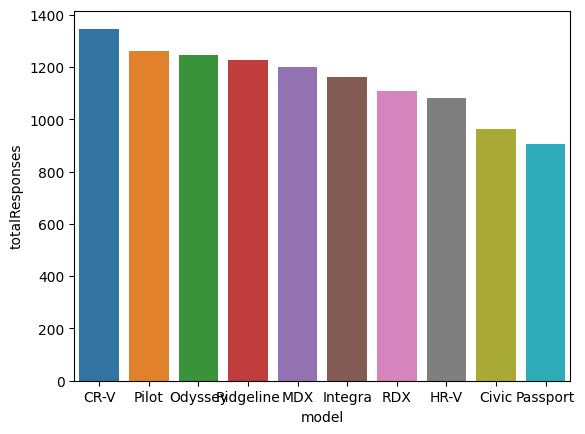

In [25]:
print_viz_results(q4)

We still recieve everything else in the result such as the summary and Cypher info.

In [26]:
print_answer(q4)

Show me in a chart which models have the most responses.
**Models with the Most Responses:**

1. **CR-V**: 1347 responses
2. **Pilot**: 1261 responses
3. **Odyssey**: 1245 responses
4. **Ridgeline**: 1228 responses
5. **MDX**: 1199 responses
6. **Integra**: 1163 responses
7. **RDX**: 1110 responses
8. **HR-V**: 1080 responses
9. **Civic**: 965 responses
10. **Passport**: 904 responses


In [27]:
print_cypher_queries(q4)

Which models have the most responses?

MATCH (v:Verbatim)
WITH v.model AS model, COUNT(v) AS totalResponses
RETURN model, totalResponses
ORDER BY totalResponses DESC
LIMIT 10


